# Campus Analytics Challenge 2022
## Author: Eric Wilson
## Date Created: 30 June 2022

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load Training Data
training = pd.read_excel('dbb4c4ff1f31-CAC+2022_Training+Data+Set+New.xlsx')
print(training.head)

<bound method NDFrame.head of       sor                cdf_seq_no  \
0      HH        T20110701260061756   
1      HH       T201302289909010349   
2      HH  T20130726991361190114550   
3      BK       T201207095780929968   
4      HH  T20131230990558080004939   
...    ..                       ...   
39995  HH  T20130726991321130015959   
39996  HH       T201208319925685298   
39997  HH        T20111004560028307   
39998  HH        T20110601320040304   
39999  HH       T201208319925581644   

                                              trans_desc  merchant_cat_code  \
0      RECUR DEBIT CRD PMT11/11 DELTA DENTAL OF A11 O...             6300.0   
1      CHECK CRD PURCHASE 11/11 SURETY SOLUTIONS,    ...                NaN   
2      CHECK CRD PURCHASE 11/11 THE COPY STOP        ...                NaN   
3               MARKET ALERT INC         111-111-1111 TX             7375.0   
4      CHECK CRD PURCHASE 11/11 PERT- NER PERFECT    ...                NaN   
...                        

## Data Exploration

In [3]:
print(training.dtypes)

sor                            object
cdf_seq_no                     object
trans_desc                     object
merchant_cat_code             float64
amt                           float64
db_cr_cd                       object
payment_reporting_category     object
payment_category               object
is_international                 bool
default_brand                  object
default_location               object
qrated_brand                   object
coalesced_brand                object
Category                       object
dtype: object


In [4]:
for k in ('sor', 'db_cr_cd', 'payment_reporting_category', 'is_international', 'Category'):
    print(training[k].value_counts())

HH    39688
BK      312
Name: sor, dtype: int64
D    37962
C     1726
Name: db_cr_cd, dtype: int64
Card    40000
Name: payment_reporting_category, dtype: int64
False    38855
True      1145
Name: is_international, dtype: int64
Retail Trade                                 13500
Entertainment                                11255
Trade, Professional and Personal Services     5275
Health and Community Services                 4157
Services to Transport                         2317
Travel                                        1489
Property and Business Services                1095
Education                                      445
Communication Services                         282
Finance                                        185
Name: Category, dtype: int64


All classes, including the target feature, are imbalanced. Care must be taken for high precision in for 'Retail Trade', and high sensitivity for 'Finance' and 'Communication Services'.

In [5]:
# Check Missing Values
print(training.isnull().sum())

sor                               0
cdf_seq_no                        0
trans_desc                        0
merchant_cat_code             15309
amt                               0
db_cr_cd                        312
payment_reporting_category        0
payment_category                  0
is_international                  0
default_brand                     0
default_location                  6
qrated_brand                   3327
coalesced_brand                   0
Category                          0
dtype: int64


count    40000.000000
mean        75.870519
std        254.587351
min          0.010000
25%         14.007500
50%         29.990000
75%         63.650000
max      23313.800000
Name: amt, dtype: float64

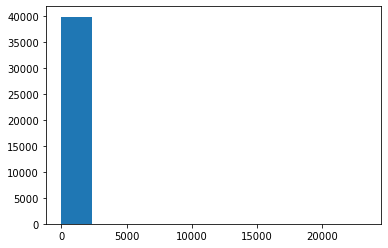

In [6]:
plt.hist(training['amt'])
training['amt'].describe() # amt has a heavy right skew

## Data Preparation

In [7]:
# Convert Categorical Variables
for k in ('sor', 'db_cr_cd', 'is_international', 'Category'):
    training[k] = training[k].astype('category')

In [8]:
del training['payment_reporting_category'] # single value categorical variable
del training['default_brand'] # Redundant
del training['qrated_brand'] # Redundant

## Natural Language Processing with Linear SVM

In [9]:
training['coalesced_brand'] = training['coalesced_brand'].astype('string') # Some names were not read as strings

In [10]:
# Create Document-Term Matrix
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
brand_train_counts = tfidf_vect.fit_transform(training['coalesced_brand'])

In [11]:
brand_train_counts.shape

(40000, 25931)

In [12]:
from scipy import sparse
brand_sparse = pd.DataFrame.sparse.from_spmatrix(brand_train_counts, columns=tfidf_vect.get_feature_names_out())

In [13]:
from sklearn.model_selection import train_test_split
brand_train, brand_validation, category_train, category_validation = train_test_split(
    training['coalesced_brand'], training['Category'], test_size=.2, random_state = 42)

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),])

text_clf.fit(brand_train, category_train) 
predicted = text_clf.predict(brand_validation)
np.mean(predicted == category_validation)

0.714375

An SVM using only company names results in 71.4% accuracy

In [15]:
from sklearn import metrics
print(metrics.classification_report(
    category_validation, 
    predicted, 
    target_names=category_validation.cat.categories))

                                           precision    recall  f1-score   support

                   Communication Services       0.69      0.29      0.40        63
                                Education       0.74      0.24      0.37        95
                            Entertainment       0.85      0.73      0.78      2295
                                  Finance       0.60      0.26      0.36        35
            Health and Community Services       0.85      0.79      0.82       850
           Property and Business Services       0.86      0.25      0.38       222
                             Retail Trade       0.59      0.88      0.70      2619
                    Services to Transport       0.78      0.62      0.69       463
Trade, Professional and Personal Services       0.85      0.50      0.63      1057
                                   Travel       0.81      0.50      0.61       301

                                 accuracy                           0.71      8000
  

Precision averages to ~75% overall. Recall is low for 'Education', 'Finance', and 'Property and Business Services'.

## Linear SVM with Additional Features

In [16]:
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
cat_list = ['sor', 'db_cr_cd', 'is_international']
enc.fit(training[cat_list])
sparse_cats = enc.transform(training[cat_list])
cats_df = pd.DataFrame.sparse.from_spmatrix(sparse_cats, columns = enc.get_feature_names_out())

In [17]:
training_svm_f = pd.concat([cats_df, brand_sparse], axis = 1)
bank_train_f, bank_validation_f, cat_train_f, cat_validation_f = train_test_split(
    training_svm_f, 
    training['Category'], 
    test_size=.2, 
    random_state = 42)
svm_clf_f = SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)
svm_clf_f.fit(bank_train_f, cat_train_f)
svm_predicted_f = svm_clf_f.predict(bank_validation_f)
np.mean(svm_predicted_f == cat_validation_f)

0.690625

In [18]:
print(metrics.classification_report(
    cat_validation_f, 
    svm_predicted_f, 
    target_names=cat_validation_f.cat.categories))

                                           precision    recall  f1-score   support

                   Communication Services       0.88      0.24      0.37        63
                                Education       0.71      0.13      0.21        95
                            Entertainment       0.87      0.68      0.76      2295
                                  Finance       0.70      0.20      0.31        35
            Health and Community Services       0.88      0.75      0.81       850
           Property and Business Services       0.91      0.18      0.31       222
                             Retail Trade       0.54      0.90      0.68      2619
                    Services to Transport       0.80      0.58      0.67       463
Trade, Professional and Personal Services       0.88      0.46      0.60      1057
                                   Travel       0.83      0.47      0.60       301

                                 accuracy                           0.69      8000
  

This model is less accurate overall with 69% compared to 71%, but has a higher precision of 76% compared to 75%. Recall is worse across the board.

## Linear SVM with Merchant Category Code

In this next model, category codes are treated as categorical variables.

In [19]:
merch_cat_codes = training['merchant_cat_code'].astype('category')
enc_mc = preprocessing.OneHotEncoder(handle_unknown='ignore')
enc_mc.fit(merch_cat_codes.array.reshape(-1,1))
merch_cat_codes = pd.DataFrame.sparse.from_spmatrix(
    enc_mc.transform(
        merch_cat_codes.array.reshape(-1,1)), 
    columns = enc_mc.get_feature_names_out())
training_svm_mc = pd.concat([merch_cat_codes, brand_sparse], axis = 1)
bank_train_mc, bank_validation_mc, cat_train_mc, cat_validation_mc = train_test_split(
    training_svm_mc, 
    training['Category'], 
    test_size=.2, 
    random_state = 42)
svm_clf_mc = SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)
svm_clf_mc.fit(bank_train_mc, cat_train_mc)
svm_predicted_mc = svm_clf_mc.predict(bank_validation_mc)
np.mean(svm_predicted_mc == cat_validation_mc)

0.774

This is the most accurate so far, at 77.4%.

In [20]:
print(metrics.classification_report(
    cat_validation_mc, 
    svm_predicted_mc, 
    target_names=cat_validation_mc.cat.categories))

                                           precision    recall  f1-score   support

                   Communication Services       0.79      0.65      0.71        63
                                Education       0.68      0.59      0.63        95
                            Entertainment       0.86      0.81      0.83      2295
                                  Finance       0.88      0.20      0.33        35
            Health and Community Services       0.91      0.85      0.88       850
           Property and Business Services       0.68      0.57      0.62       222
                             Retail Trade       0.67      0.86      0.75      2619
                    Services to Transport       0.73      0.77      0.75       463
Trade, Professional and Personal Services       0.89      0.61      0.73      1057
                                   Travel       0.81      0.47      0.59       301

                                 accuracy                           0.77      8000
  

Precision is also higher, at an average of 79%. 'Finance', however, retains lower sensitivity at .20.

## Linear SVM, Combined Model

In [21]:
training_svm_c = pd.concat([merch_cat_codes, cats_df, brand_sparse], axis = 1)
bank_train_c, bank_validation_c, cat_train_c, cat_validation_c = train_test_split(
    training_svm_c, 
    training['Category'], 
    test_size=.2, 
    random_state = 42)
svm_clf_c = SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)
svm_clf_c.fit(bank_train_c, cat_train_c)
svm_predicted_c = svm_clf_c.predict(bank_validation_c)
np.mean(svm_predicted_c == cat_validation_c)

0.75825

The combined model is less accurate than that with only the merchant names and codes at 75.8%.

In [22]:
print(metrics.classification_report(
    cat_validation_c, 
    svm_predicted_c, 
    target_names=cat_validation_c.cat.categories))

                                           precision    recall  f1-score   support

                   Communication Services       0.83      0.62      0.71        63
                                Education       0.67      0.43      0.53        95
                            Entertainment       0.87      0.77      0.82      2295
                                  Finance       0.80      0.11      0.20        35
            Health and Community Services       0.91      0.84      0.87       850
           Property and Business Services       0.67      0.56      0.61       222
                             Retail Trade       0.64      0.87      0.74      2619
                    Services to Transport       0.74      0.73      0.73       463
Trade, Professional and Personal Services       0.89      0.59      0.71      1057
                                   Travel       0.82      0.46      0.58       301

                                 accuracy                           0.76      8000
  

Overall precision is also lower, albeit slightly at 78%.

## k-Nearest Neighbor Classification with Best Features from SVM

Stacking will be attempted with kNN for increased accuracy beyond 79%, and higher precisin than 79%. First, we determine the optimal k value for kNN classification.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
k_param_grid = [{'n_neighbors' : [5, 10, 100, 200]}] # sqrt(N) = 200
kNN = KNeighborsClassifier(algorithm='brute')
k_search = GridSearchCV(estimator = kNN, param_grid = k_param_grid, scoring = 'accuracy')
k_search.fit(bank_train_mc, cat_train_mc) # Start with the best model from SVM

GridSearchCV(estimator=KNeighborsClassifier(algorithm='brute'),
             param_grid=[{'n_neighbors': [5, 10, 100, 200]}],
             scoring='accuracy')

In [24]:
results_df = pd.DataFrame(k_search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
10,{'n_neighbors': 10},1,0.745031,0.008527
100,{'n_neighbors': 100},2,0.730844,0.004779
200,{'n_neighbors': 200},3,0.700719,0.006895
5,{'n_neighbors': 5},4,0.677094,0.021935


kNN classification with 10 nearest neighbors results in the highest accuracy, at 74.5%

In [25]:
k_predict = k_search.predict(bank_validation_mc)
print(np.mean(k_predict == cat_validation_mc))
print(metrics.classification_report(
    cat_validation_mc, 
    k_predict, 
    target_names=cat_validation_mc.cat.categories))

0.729625
                                           precision    recall  f1-score   support

                   Communication Services       0.74      0.68      0.71        63
                                Education       0.66      0.60      0.63        95
                            Entertainment       0.86      0.72      0.78      2295
                                  Finance       0.69      0.26      0.37        35
            Health and Community Services       0.88      0.79      0.83       850
           Property and Business Services       0.60      0.34      0.44       222
                             Retail Trade       0.62      0.87      0.72      2619
                    Services to Transport       0.80      0.59      0.68       463
Trade, Professional and Personal Services       0.77      0.62      0.69      1057
                                   Travel       0.83      0.39      0.53       301

                                 accuracy                           0.73    

Accuracy on the validation set is 73%, with a weighted precision of 75%. Sensitivity to 'Finance' is better than the best SVM model at .26, but there is still room for improvement.

## Multinomial Logistic Regression

We create a logistic regression to attempt increased precision.

In [26]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='saga', multi_class='multinomial') # saga because the data is sparse and multinomial
log_reg.fit(bank_train_mc, cat_train_mc)
log_predict = log_reg.predict(bank_validation_mc)
print(np.mean(log_predict == cat_validation_mc))

0.80025


Logistic Regression appears to have the highest accuracy, at 80.0%.

In [27]:
print(metrics.classification_report(
    cat_validation_mc, 
    log_predict, 
    target_names=cat_validation_mc.cat.categories,
    zero_division=0))

                                           precision    recall  f1-score   support

                   Communication Services       0.87      0.71      0.78        63
                                Education       0.71      0.56      0.62        95
                            Entertainment       0.86      0.84      0.85      2295
                                  Finance       0.60      0.09      0.15        35
            Health and Community Services       0.92      0.85      0.89       850
           Property and Business Services       0.72      0.62      0.67       222
                             Retail Trade       0.71      0.87      0.78      2619
                    Services to Transport       0.83      0.72      0.77       463
Trade, Professional and Personal Services       0.87      0.68      0.76      1057
                                   Travel       0.85      0.58      0.69       301

                                 accuracy                           0.80      8000
  

Precision is also the highest, with a weighted average of 81%. Recall for finance is very low, at .09.

## Stacking of SVM, kNN, and Logit Models with Perceptron

We combine the three best models with a perceptron to attempt higher precision and better recall.

In [28]:
from sklearn.linear_model import Perceptron
from sklearn.ensemble import StackingClassifier
stack_estimators = [
    ('svm_final', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
    ('knn', KNeighborsClassifier(n_neighbors = 10, algorithm = 'brute')),
    ('logit', LogisticRegression(solver='saga', multi_class='multinomial'))
]

stack_clf = StackingClassifier(estimators = stack_estimators, final_estimator=Perceptron())
stack_clf.fit(bank_train_mc, cat_train_mc) # Sparse features from merchant code and coalesced brand

StackingClassifier(estimators=[('svm_final',
                                SGDClassifier(alpha=0.001, max_iter=5,
                                              random_state=42, tol=None)),
                               ('knn',
                                KNeighborsClassifier(algorithm='brute',
                                                     n_neighbors=10)),
                               ('logit',
                                LogisticRegression(multi_class='multinomial',
                                                   solver='saga'))],
                   final_estimator=Perceptron())

In [29]:
stack_prediction = stack_clf.predict(bank_validation_mc)
print(np.mean(stack_prediction == cat_validation_mc))
print(metrics.classification_report(
    cat_validation_mc, 
    stack_prediction, 
    target_names=cat_validation_mc.cat.categories,
    zero_division=0))

0.790625
                                           precision    recall  f1-score   support

                   Communication Services       0.86      0.68      0.76        63
                                Education       0.79      0.35      0.48        95
                            Entertainment       0.91      0.78      0.84      2295
                                  Finance       0.72      0.37      0.49        35
            Health and Community Services       0.88      0.88      0.88       850
           Property and Business Services       0.83      0.51      0.64       222
                             Retail Trade       0.68      0.90      0.77      2619
                    Services to Transport       0.92      0.57      0.70       463
Trade, Professional and Personal Services       0.83      0.72      0.77      1057
                                   Travel       0.85      0.63      0.72       301

                                 accuracy                           0.79    

With the stacked model, accuracy is reduced compared to the logistic model, with the approximate precision of 81%. It has a better spread of f1-scores for the categories, however, with a low of .43 compared to .15 for logistic regression, .37 for kNN, and .33 for SVM. This is a better model because it is more robust to possible class imbalance, particularly with higher precision in 'Retail Trade' and higher sensitivity in 'Finance'.

## Make predictions on Holdout Set

In [30]:
# Load Test Data
test = pd.read_excel('dbb4c4ff1f31-CAC+2022_Test+Data+Set+New.xlsx')
# Preprocess Test Data
for k in ('sor', 'db_cr_cd', 'is_international', 'Category'):
    test[k] = test[k].astype('category')
del test['payment_reporting_category'] # single value categorical variable
del test['default_brand'] # Redundant
del test['qrated_brand'] # Redundant
test['coalesced_brand'] = test['coalesced_brand'].astype('string')
brand_test_counts = tfidf_vect.transform(test['coalesced_brand'])
test_brand_sparse = pd.DataFrame.sparse.from_spmatrix(brand_test_counts, columns=tfidf_vect.get_feature_names_out())
test_cat_codes = test['merchant_cat_code'].astype('category')
test_cat_codes = pd.DataFrame.sparse.from_spmatrix(
    enc_mc.transform(
        test_cat_codes.array.reshape(-1,1)), 
    columns = enc_mc.get_feature_names_out())
test_df = pd.concat([test_cat_codes, test_brand_sparse], axis = 1)
# Make predictions on test data
test_prediction = stack_clf.predict(test_df)

In [31]:
# Write predictions to .csv file
test_pred_df = pd.DataFrame(test_prediction, columns=['Predicted Category'])
test_pred_df.to_csv('predictions.csv')

In [32]:
test_original = pd.read_excel('dbb4c4ff1f31-CAC+2022_Test+Data+Set+New.xlsx')
test_original['Category'] = test_pred_df
test_original.to_csv('CAC_2022_Test_Data_Set_with_Categories_Identified.csv', index = False)